In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, \
                            r2_score, mean_absolute_error

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

set_seed(455)
np.random.seed(455)

In [30]:
def evaluate_model(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    r2 = r2_score(test, predicted)
    msle = mean_squared_log_error(test, predicted)
    mape = np.mean(np.abs((test - predicted) / test)) * 100

    print(f"The root mean squared error (RMSE) is {rmse:.2f}")
    print(f"The Mean Absolute Error (MAE) is {mae:.2f}")
    print(f"The R-squared (R²) score is {r2:.4f}\n")
    print(f"The Mean Squared Logarithmic Error (MSLE) is {msle:.6f}")
    print(f"The Mean Absolute Percentage Error (MAPE) is {mape:.2f}%.")

In [31]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Bitcoin Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price ($)")
    plt.legend()
    plt.show()

In [32]:
dataset = pd.read_csv('bitcoin_preprocessed.csv', parse_dates=['Date'], index_col = "Date")

In [33]:
dataset

,Close,Open,High,Low,Volume,Change %,Average
Date,,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,80.0,0.00%,0.10
2010-07-19,0.1,0.1,0.1,0.1,570.0,0.00%,0.10
2010-07-20,0.1,0.1,0.1,0.1,260.0,0.00%,0.10
2010-07-21,0.1,0.1,0.1,0.1,580.0,0.00%,0.10
2010-07-22,0.1,0.1,0.1,0.1,2160.0,0.00%,0.10
...,...,...,...,...,...,...,...
2024-12-28,95284.5,94274.9,95684.3,94124.7,32970.0,1.07%,94904.50
2024-12-29,93716.3,95282.6,95315.4,93026.7,47710.0,-1.65%,94171.05
2024-12-30,92779.8,93718.7,94936.4,91522.3,112430.0,-1.00%,93229.35


In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5282 entries, 2010-07-18 to 2025-01-01
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     5282 non-null   float64
 1   Open      5282 non-null   float64
 2   High      5282 non-null   float64
 3   Low       5282 non-null   float64
 4   Volume    5282 non-null   float64
 5   Change %  5282 non-null   object 
 6   Average   5282 non-null   float64
dtypes: float64(6), object(1)
memory usage: 330.1+ KB


In [35]:
dataset.shape

(5282, 7)

In [36]:
# Create Moving Averages (Feature Engineering)
#dataset["SMA_10"] = dataset["Close"].rolling(window=10).mean()
#dataset["EMA_10"] = dataset["Close"].ewm(span=10, adjust=False).mean()

# Drop NaN values from moving averages
#dataset.dropna(inplace=True)

# Define training and testing periods
tstart = "2010-07-18"
tend = "2024-10-01"

In [37]:
def train_test_split(dataset, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = dataset.loc[tstart:tend, "Close"].values
    test = dataset.loc[tend_next:, "Close"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)

In [38]:
len(training_set)

5190

In [39]:
len(test_set)

92

In [40]:
sc = MinMaxScaler()
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [41]:
training_set_scaled

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.89791176],
       [0.86687278],
       [0.8326066 ]])

In [42]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 120  # Number of time steps to look back
features = 1

X_train, y_train = split_sequence(training_set_scaled, n_steps)

# Reshape for GRU model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

In [43]:
X_train.shape[1]

120

In [44]:
# The LSTM architecture
model_gru = Sequential()
model_gru.add(GRU(units=256, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
# Compiling the model
model_gru.compile(optimizer="RMSprop", loss="mean_squared_error")

model_gru.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 256)                 │         198,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 199,169 (778.00 KB)

 Trainable params: 199,169 (778.00 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
early_stop = EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    "default_gru.keras",  # File to save the model
    monitor="loss",  # Metric to track (e.g., validation loss)
    save_best_only=True,  # Save only if the model improves
    mode="min",  # Save when 'loss' decreases
    verbose=1  # Print messages when saving
)

model_gru.fit(X_train, y_train, epochs=25, batch_size=32, callbacks=[early_stop, checkpoint], verbose=1)

Epoch 1/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - loss: 0.0089
Epoch 1: loss improved from inf to 0.00250, saving model to default_gru.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 53s 317ms/step - loss: 0.0088
Epoch 2/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 6.4274e-04
Epoch 2: loss improved from 0.00250 to 0.00060, saving model to default_gru.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 82s 320ms/step - loss: 6.4246e-04
Epoch 3/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - loss: 4.9931e-04
Epoch 3: loss improved from 0.00060 to 0.00047, saving model to default_gru.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 51s 320ms/step - loss: 4.9915e-04
Epoch 4/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - loss: 4.3158e-04
Epoch 4: loss improved from 0.00047 to 0.00041, saving model to default_gru.keras
159/159 ━━━━━━━━━━━━━━━━━━━━ 83s 327ms/step - loss: 4.3145e-04
Epoch 5/25
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - loss: 3.8752e-04
Epoch 5: loss improved from 0.00041 to 0.00037, saving model to def

In [46]:
#model_gru = load_model("default_gru.keras")

In [47]:
#model_gru.fit(X_train, y_train, epochs=25, batch_size=32, callbacks=[early_stop, checkpoint], verbose=1)

In [48]:
# Model 1: GRU (50 Epochs, StandardScaler, early stopping, dropouts, Close, batchsize=32, n_steps=120, optimizer=Adam)
"""Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 227ms/step - loss: 0.0078"""

# ---

# Model 2: GRU (50 Epochs, MinMaxScaler, early stopping, dropouts, Close, batchsize=32, n_steps=120, optimizer=Adam)
"""Epoch 19/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 225ms/step - loss: 3.2570e-04"""
# RMSE: 2712.30

# ---

# Model 3 GRU (50 Epochs, StandardScaler, early stopping, dropouts, Close, batchsize=32, n_steps=120, optimizer=Adam)
# Bez sensu

# ---

# Model 4 GRU (50 Epochs, StandardScaler, early stopping, dropouts, Close, batchsize=32, n_steps=120, optimizer=RMSprop)
"""Epoch 23/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 43s 227ms/step - loss: 0.0081
The root mean squared error is 2611.39
The Mean Absolute Error (MAE) is 1865.43
The R-squared (R²) score is 0.9842

The Mean Squared Logarithmic Error (MSLE) is 0.003290
The Mean Absolute Percentage Error (MAPE) is 63.39%."""

# ---

# Model 5 GRU (50 Epochs, StandardScaler, early stopping, NO dropouts, Close, batchsize=32, n_steps=120, optimizer=RMSprop)
"""Epoch 50/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 42s 215ms/step - loss: 0.0032
The root mean squared error is 2823.36
The Mean Absolute Error (MAE) is 1452.78
The R-squared (R²) score is 0.9815

The Mean Squared Logarithmic Error (MSLE) is 0.001752
The Mean Absolute Percentage Error (MAPE) is 61.78%."""

# ---> NONSENSE

# Model 6 GRU + LSTM (50 Epochs, MinMaxScaler, early stopping, NO dropouts, Close, batchsize=32, n_steps=60, optimizer=RMSprop)
"""Epoch 50/50
129/129 ━━━━━━━━━━━━━━━━━━━━ 21s 162ms/step - loss: 1.4298e-04
The root mean squared error is 2689.83
The Mean Absolute Error (MAE) is 1915.69
The R-squared (R²) score is 0.9833

The Mean Squared Logarithmic Error (MSLE) is 0.002702
The Mean Absolute Percentage Error (MAPE) is 60.97%."""

# ---

# Model 7 LSTM + GRU (50 Epochs, MinMaxScaler, early stopping, NO dropouts, Close, batchsize=32, n_steps=30, optimizer=RMSprop)
"""Epoch 50/50
130/130 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - loss: 1.8203e-04
The root mean squared error is 1777.97
The Mean Absolute Error (MAE) is 1125.94
The R-squared (R²) score is 0.9927

The Mean Squared Logarithmic Error (MSLE) is 0.001274
The Mean Absolute Percentage Error (MAPE) is 62.72%."""

# --- Explore more epochs in simple LSTM and GRU + extend training set to the end of 2022 (all same -> 100 epochs, n_steps=60)
# LSTM:
"""
Epoch 100/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 1.1724e-04
The root mean squared error is 1654.12
The Mean Absolute Error (MAE) is 1092.90
The R-squared (R²) score is 0.9942

The Mean Squared Logarithmic Error (MSLE) is 0.000872
The Mean Absolute Percentage Error (MAPE) is 58.63%.
"""

# ---
# LSTM: (all same -> StandardScaler, 100 epochs, n_steps=60)
"""
tstart = "2010-07-18"
tend = "2024-11-01
"""
"""The root mean squared error is 3056.52
The Mean Absolute Error (MAE) is 2364.14
The R-squared (R²) score is 0.9581

The Mean Squared Logarithmic Error (MSLE) is 0.001222
The Mean Absolute Percentage Error (MAPE) is 20.34%."""

# ---
# LSTM: (all same -> MinMaxScaler, 150 epochs, n_steps=60)
"""
tstart = "2017-06-01"
tend = "2024-10-01
"""
"""The root mean squared error is 2502.41
The Mean Absolute Error (MAE) is 1861.88
The R-squared (R²) score is 0.9719

The Mean Squared Logarithmic Error (MSLE) is 0.000869
The Mean Absolute Percentage Error (MAPE) is 20.82%."""


# ---
# New LSTM architecture (lstm_cryptocurrency.keras)
# ponad 3500 RMSE
"""
The root mean squared error is 4279.11
The Mean Absolute Error (MAE) is 3399.72
The R-squared (R²) score is 0.9178

The Mean Squared Logarithmic Error (MSLE) is 0.002309
The Mean Absolute Percentage Error (MAPE) is 19.90%.
"""

# Rozszerzenie danych uczących o rok
"""
The root mean squared error is 3060.83
The Mean Absolute Error (MAE) is 2381.87
The R-squared (R²) score is 0.9580

The Mean Squared Logarithmic Error (MSLE) is 0.001235
The Mean Absolute Percentage Error (MAPE) is 20.45%."""

# Default, simplest model
"""The root mean squared error is 4009.40
The Mean Absolute Error (MAE) is 3428.78
The R-squared (R²) score is 0.9279

The Mean Squared Logarithmic Error (MSLE) is 0.002376
The Mean Absolute Percentage Error (MAPE) is 20.74%."""
# zwiększenie units 125 -> 256
"""The root mean squared error is 4071.47"""
# n_steps=120

"""
The root mean squared error (RMSE) is 3127.70
The Mean Absolute Error (MAE) is 2517.05
The R-squared (R²) score is 0.9561

The Mean Squared Logarithmic Error (MSLE) is 0.001420
The Mean Absolute Percentage Error (MAPE) is 20.78%."""

# od 2016-07-09 i n_steps=120 i GRU (units=256) -> 50 epochs
"""The root mean squared error (RMSE) is 3803.78
The Mean Absolute Error (MAE) is 3231.33
The R-squared (R²) score is 0.9351

The Mean Squared Logarithmic Error (MSLE) is 0.002117
The Mean Absolute Percentage Error (MAPE) is 20.73%.
"""

'The root mean squared error (RMSE) is 3803.78\nThe Mean Absolute Error (MAE) is 3231.33\nThe R-squared (R²) score is 0.9351\n\nThe Mean Squared Logarithmic Error (MSLE) is 0.002117\nThe Mean Absolute Percentage Error (MAPE) is 20.73%.\n'

In [49]:
dataset_total = dataset.loc[:, "Close"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_gru.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


In [50]:
evaluate_model(test_set, predicted_stock_price)

The root mean squared error (RMSE) is 2452.07
The Mean Absolute Error (MAE) is 1857.39
The R-squared (R²) score is 0.9730

The Mean Squared Logarithmic Error (MSLE) is 0.000804
The Mean Absolute Percentage Error (MAPE) is 21.30%.


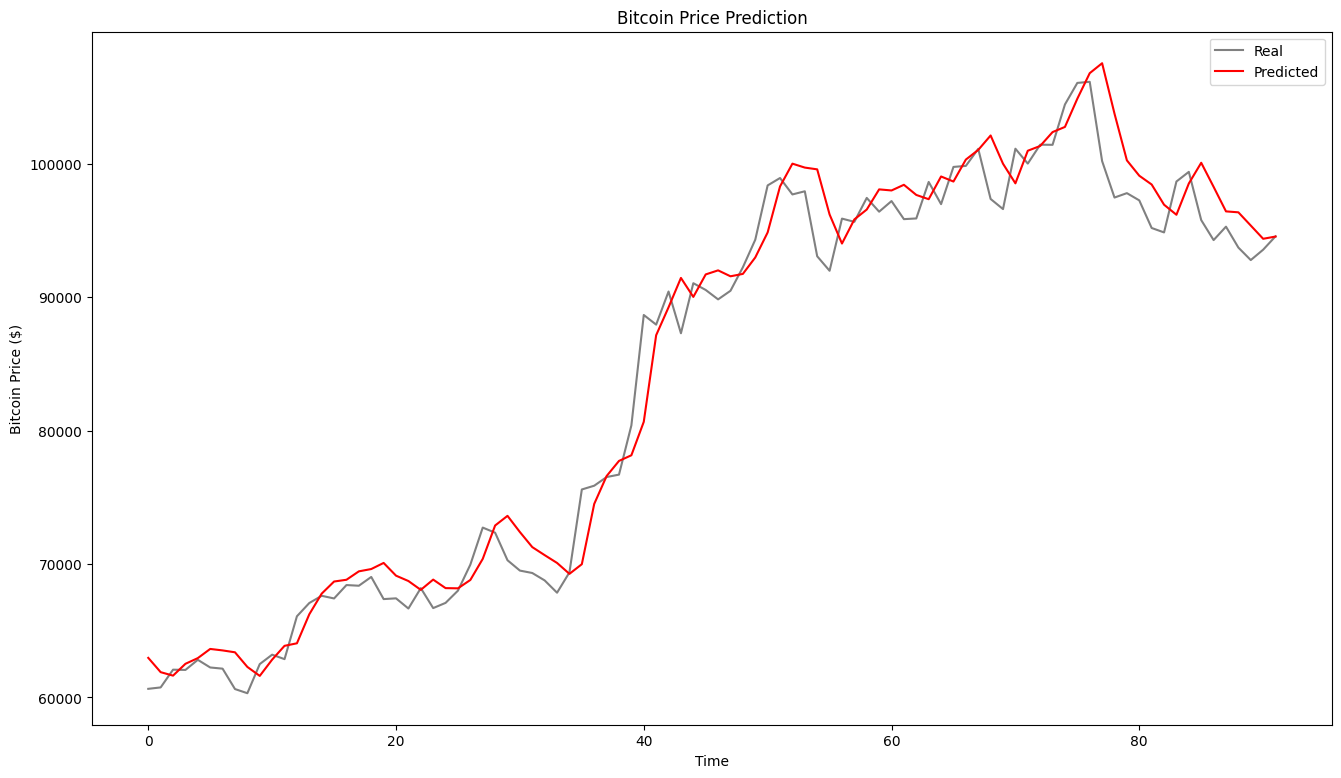

In [51]:
plot_predictions(test_set, predicted_stock_price)